## Homework 10

Gabriel Mastromatteo 1006749761

## Q1: Definitions

### Gaussian Processes (GPs) and Stochastic Processes

A **stochastic process** is a collection of random variables indexed by time or space. It models systems that evolve with uncertainty, such as stock prices over time or temperature across a region.

A **Gaussian Process (GP)** is a special kind of stochastic process where any finite collection of those random variables follows a multivariate normal distribution. It defines a distribution over functions, making it a powerful non-parametric tool for regression and prediction.

A GP is fully described by:
- A **mean function**: $\mu(x) = \mathbb{E}[f(x)]$
- A **covariance function (kernel)**: $ k(x, x') = \mathbb{E}[(f(x) - \mu(x))(f(x') - \mu(x'))] $

Mathematically:
$$ f(x) \sim \mathcal{GP}(\mu(x), k(x, x')) $$

**Applications** include:
- Spatial statistics (e.g., geostatistics and kriging)
- Bayesian optimization
- Surrogate modeling for expensive black-box functions

---

### Variational Inference (VI) and the Evidence Lower Bound (ELBO)

**Variational Inference (VI)** is a method for approximating complex posterior distributions when exact inference (e.g., via MCMC) is computationally expensive.

Instead of sampling from the true posterior $p(\theta|x)$ we:
1. Introduce a simpler, tractable distribution $ q(\theta)$
2. Minimize the **Kullback-Leibler (KL) divergence** between $ q(\theta)$ and $ p(\theta|x)$

This is done by **maximizing the Evidence Lower Bound (ELBO)**:

$$
\text{ELBO}(q) = \mathbb{E}_{q(\theta)}[\log p(x|\theta)] - \text{KL}(q(\theta) || p(\theta))
$$

Maximizing the ELBO ensures that $q(\theta)$ becomes a good approximation of the posterior.

> In practice, PyMC uses **Automatic Differentiation Variational Inference (ADVI)**, which assumes a mean-field Gaussian \( q(\theta) \), and optimizes the ELBO using gradient-based methods.

We will see a neural network example using VI and ELBO in **Q3**, again with `PyMC`.



## Q2: Gaussian Processes on a New Dataset using PyMC

We will demonstrate Gaussian Process regression using PyMC on a synthetic sine wave dataset. The model will infer a smooth function fit and uncertainty intervals using a GP prior.

### Step 1: Generate Noisy Sine Wave Data

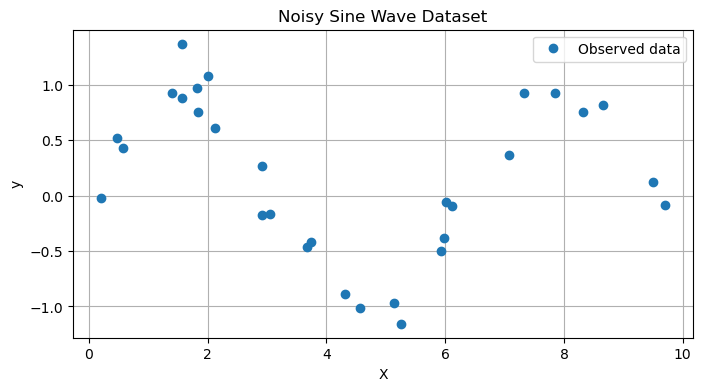

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Step 1: Generate synthetic noisy sine wave data
np.random.seed(42)
X = np.sort(np.random.uniform(0, 10, 30))[:, None]
y = np.sin(X).ravel() + np.random.normal(0, 0.2, X.shape[0])

plt.figure(figsize=(8, 4))
plt.plot(X, y, 'o', label='Observed data')
plt.title("Noisy Sine Wave Dataset")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

### Step 2: Build the Gaussian Process Model in PyMC

In [17]:
# Step 2: Fit Gaussian Process Model
with pm.Model() as gp_model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    nu = pm.HalfNormal("nu", sigma=1)
    cov = nu**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    gp = pm.gp.Marginal(cov_func=cov)

    sigma = pm.HalfNormal("sigma", sigma=1)
    y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, sigma=sigma)

    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ell, nu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 124 seconds.


### Step 3: Generate Posterior Predictions

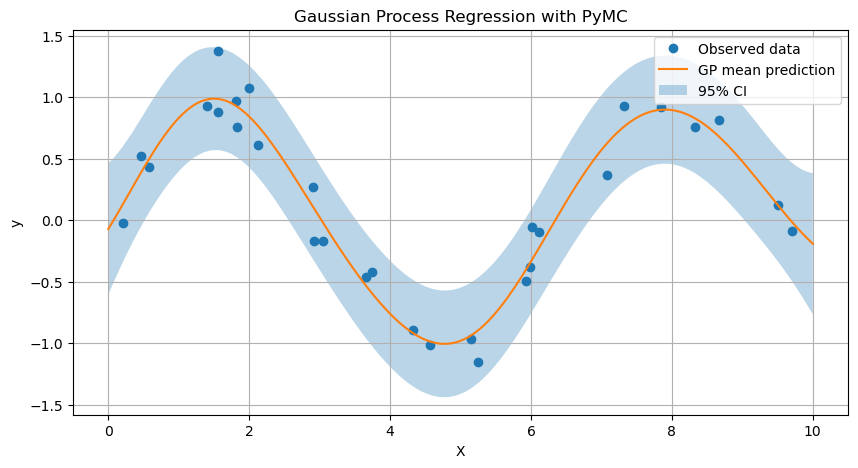

In [19]:
# Step 3 (Corrected): Predict using posterior mean values and `given=`

# Extract posterior means
ell_val = trace.posterior["ell"].mean().item()
nu_val = trace.posterior["nu"].mean().item()
sigma_val = trace.posterior["sigma"].mean().item()

# Define the GP with fixed hyperparameters
cov = nu_val**2 * pm.gp.cov.ExpQuad(1, ls=ell_val)
gp_post = pm.gp.Marginal(cov_func=cov)

# Define 'given' dictionary for prediction
given = {
    "X": X,
    "y": y,
    "sigma": sigma_val
}

# Predictive mean and variance
with pm.Model():
    mu_pred, var_pred = gp_post.predict(
        Xnew=X_new,
        given=given,
        diag=True,
        pred_noise=True
    )

# Step 4: Plot prediction with uncertainty
std_pred = np.sqrt(var_pred)
lower = mu_pred - 1.96 * std_pred
upper = mu_pred + 1.96 * std_pred

plt.figure(figsize=(10, 5))
plt.plot(X, y, "o", label="Observed data")
plt.plot(X_new, mu_pred, label="GP mean prediction")
plt.fill_between(X_new.ravel(), lower, upper, alpha=0.3, label="95% CI")
plt.title("Gaussian Process Regression with PyMC")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

## Q3: Neural Network with Variational Inference using PyMC

In [20]:
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Step 1: Generate and preprocess the dataset

In [21]:
# Generate 2D binary classification dataset
X, y = make_moons(n_samples=500, noise=0.2, random_state=0)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Shape info
X_train.shape, y_train.shape

((350, 2), (350,))

### Step 2: Build Bayesian Neural Network (BNN) in PyMC

In [23]:
with pm.Model() as bnn_model:
    # Inputs (mutable so we can update for prediction later)
    X_data = pm.MutableData("X_data", X_train)
    y_data = pm.MutableData("y_data", y_train)

    # Layer 1: Hidden layer (tanh)
    W1 = pm.Normal("W1", mu=0, sigma=1, shape=(2, 5))
    b1 = pm.Normal("b1", mu=0, sigma=1, shape=(5,))
    h1 = pt.tanh(pt.dot(X_data, W1) + b1)

    # Layer 2: Output layer (sigmoid)
    W2 = pm.Normal("W2", mu=0, sigma=1, shape=(5,))
    b2 = pm.Normal("b2", mu=0, sigma=1)
    logits = pt.dot(h1, W2) + b2
    p = pm.Deterministic("p", pm.math.sigmoid(logits))

    # Likelihood (Bernoulli)
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_data)

    # Inference: ADVI
    approx = pm.fit(n=10_000, method="advi", progressbar=True)
    bnn_trace = approx.sample(1000)

Finished [100%]: Average Loss = 192.53


### Step 3: Visualize posterior predictive surface

Sampling: []


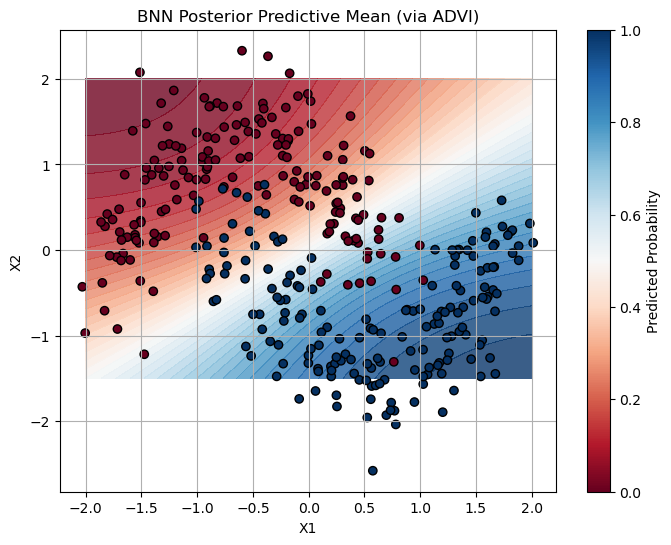

In [27]:
# Step 3: Create prediction grid
xx, yy = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-1.5, 2, 200))
grid = np.column_stack([xx.ravel(), yy.ravel()])

# Update input data for prediction
pm.set_data({"X_data": grid}, model=bnn_model)

# Posterior predictive sampling
with bnn_model:
    preds = pm.sample_posterior_predictive(bnn_trace, var_names=["p"])

# Compute posterior mean prediction, reshape to match grid
mean_preds = preds.posterior_predictive["p"].mean(dim=("chain", "draw")).values.reshape(xx.shape)

# Plot decision surface
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, mean_preds, levels=50, cmap="RdBu", alpha=0.8)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="RdBu", edgecolors="k")
plt.title("BNN Posterior Predictive Mean (via ADVI)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Predicted Probability")
plt.grid(True)
plt.show()